In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json
import os

In [2]:
def eval_measure(test, pred, test_th = 0.02, pred_th = 0.24):
    TP, FP, TN, FN = 0,0,0,0
    for i in range(len(test)):
        if(test[i] >test_th):
            if(pred[i]>pred_th):
                TP+=1
            elif(pred[i]<=pred_th):
                FN +=1
        elif(test[i]<=test_th):
            if(pred[i]>pred_th):
                FP +=1
            elif(pred[i]<=pred_th):
                TN+=1
    if(TP+FP==0):
        print("TP+FP==0")
        return (0,0,0)
    if(TP+FN==0):
        print("TP+FN==0")
        return (0,0,0)

    pre = TP/(TP+FP)   
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    

In [ ]:
normal_pc = np.load("../../data/SWaT/normal_pc.npy")
anomaly_pc = np.load("../../data/SWaT/anomaly_pc.npy")
if("cai_checkpoints" not in os.listdir()):
    os.mkdir("cai_checkpoints")




In [63]:

normal_len = len(normal_pc)
anomaly_len = len(anomaly_pc)
dimension = normal_pc.shape[1]
sample_size = 100

# Train
train_sample_step = 20
train_size = (normal_len-sample_size)//train_sample_step
train_index = np.arange(normal_len, train_sample_step)[:train_size]

print("train_sample_step: ", train_sample_step, ", train_size: ", train_size)

train_x = np.zeros((train_size, sample_size, dimension), dtype="double")
for i in range(train_size):
    train_x[i, :, :] = normal_pc[i*train_sample_step: (i*train_sample_step+sample_size), :]

train_y = np.zeros(train_size)

test_sample_step = 7
test_size = (anomaly_len-sample_size)//test_sample_step
print("test_sample_step: ", test_sample_step, "test size:", test_size)
test_index = np.array([i*test_sample_step for i in range(test_size)])
test_x = np.zeros((test_size, sample_size, dimension), dtype = "double")
for i in range(test_size):
    test_x[i,:,:] = anomaly_pc[test_index[i]:(test_index[i]+sample_size), :-1]
test_attack_level = np.array([np.mean(anomaly_pc[i:(i+sample_size), -1]) for i in test_index])
test_y = test_attack_level

X_train = np.concatenate((train_x, test_x), axis=0)
y_train = np.concatenate((np.zeros(train_size), np.ones(test_size)))

train_sample_step:  20 , train_size:  24745
test_sample_step:  7 test size: 64259


In [6]:



model_deep_dropout_sigmoid = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu,\
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_deep_dropout_sigmoid.compile(optimizer="Adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=["accuracy"])


W0901 18:11:30.938639 4635657664 deprecation.py:506] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 18:11:31.216025 4635657664 deprecation.py:323] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
prev_epoch=0

In [3]:

model_deep_dropout_sigmoid.load_weights("cai_checkpoints/model_deep_dropout_sigmoid_weights_epoch"+str(prev_epoch)+".h5")

print("previous:")
test_pred = model_deep_dropout_sigmoid.predict(test_x).ravel()
test_pred = -np.log(1+1e-10-test_pred)
print("After log:", pd.Series(test_pred).describe())




In [9]:
prev_epoch = 2
for epoch in range(prev_epoch+1,prev_epoch+2):
    print("***********epoch: ", epoch)
    model_deep_dropout_sigmoid.fit(X_train, y_train, epochs=3)
    # eval model
    train_pred = model_deep_dropout_sigmoid.predict(train_x).ravel()
    #train_pred_mse = np.array([mean_squared_error(train_y[i], train_pred[i]) for i in range(len(train_y))])
    #pd.Series(train_pred_mse).describe()
    test_pred = model_deep_dropout_sigmoid.predict(test_x).ravel()
    #test_pred_mse = np.array([mean_squared_error(test_y[i], test_pred[i])for i in range(len(test_y))])
    #pd.Series(test_pred_mse).describe()
    print("len test_pred: ", test_pred.shape, "len test_attack_level:", test_attack_level.shape)
    print("corr in test: ", np.corrcoef(test_pred, test_attack_level))
    res = {}
    check_num = 100
    if(epoch == 0):
        check_num = 2
    test_pred = -np.log(1+1e-10-test_pred)
    print("after log:", pd.Series(test_pred).describe())
    pred_mean = np.mean(test_pred)
    pred_std = np.std(test_pred)
    lower_bound = np.quantile(test_pred, 0.5)
    upper_bound = np.quantile(test_pred, 0.99)
    
    for i in np.linspace(lower_bound,upper_bound, check_num):
        res[str(i)] = eval_measure(test_attack_level, test_pred, test_th=1/(sample_size+1.0), pred_th=i)
        print("pred_th = ",i, ", pre, rec, f1 =",res[str(i)])
    np.save("cai_checkpoints/pred_epoch"+str(epoch)+".npy", test_pred)
    with open("cai_checkpoints/res_epoch"+str(epoch)+".txt", "w") as f:
        f.write(str(res))
    #model_deep_dropout_sigmoid.fit(X_train, y_train, epochs=2)
    model_deep_dropout_sigmoid.save_weights("cai_checkpoints/model_deep_dropout_sigmoid_weights_epoch"+str(epoch)+".h5")
    #model_deep_dropout_sigmoid.fit(X_train, y_train,epochs=2)






***********epoch:  1
Epoch 1/3
69733/69733 [==============================] - 56s 797us/sample - loss: 0.9113 - acc: 0.6450
Epoch 2/3
69733/69733 [==============================] - 55s 793us/sample - loss: 0.6506 - acc: 0.6451
Epoch 3/3
69733/69733 [==============================] - 56s 802us/sample - loss: 0.6506 - acc: 0.6451
len test_pred:  (44986,) len test_attack_level: (44986,)
corr in test:  [[ 1.00000000e+00 -9.84447142e-04]
 [-9.84447142e-04  1.00000000e+00]]
after log: count    44986.000000
mean         1.053669
std          0.000078
min          1.053591
25%          1.053591
50%          1.053591
75%          1.053591
max          1.053591
dtype: float64
TP+FP==0
pred_th =  1.0535913705825806 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0535913705825806 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0535913705825806 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0535913705825806 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  1.0535913705825806 , pre, rec, f1 = (0, 0

In [11]:
pd.Series(train_pred).describe()

count    24747.000000
mean         0.651363
std          0.000047
min          0.651317
25%          0.651317
50%          0.651317
75%          0.651317
max          0.651317
dtype: float64

In [66]:


############## train this once, get good result
model_small_dropout_sigmoid2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(1000, activation=tf.nn.relu, \
    #                      kernel_regularizer = tf.keras.regularizers.l2(0.01),\
     #                   activity_regularizer = tf.keras.regularizers.l1(0.01)), 
    #tf.keras.layers.Dropout(0.4),
    ##tf.keras.layers.Dense(1000, activation=tf.nn.relu,\
     #                     kernel_regularizer = tf.keras.regularizers.l2(0.01),\
     #                   activity_regularizer = tf.keras.regularizers.l1(0.01)),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    #tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(10, activation=tf.nn.relu, \
    #                      kernel_regularizer = tf.keras.regularizers.l2(0.01),\
    #                    activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_small_dropout_sigmoid2.compile(optimizer="Adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=["accuracy"])


In [67]:
prev_epoch = 2
for epoch in range(prev_epoch+1,prev_epoch+2):
    print("***********epoch: ", epoch)
    model_small_dropout_sigmoid2.fit(X_train, y_train, epochs=3)
    # eval model
    train_pred = model_small_dropout_sigmoid2.predict(train_x).ravel()
    #train_pred_mse = np.array([mean_squared_error(train_y[i], train_pred[i]) for i in range(len(train_y))])
    #pd.Series(train_pred_mse).describe()
    test_pred = model_small_dropout_sigmoid2.predict(test_x).ravel()
    #test_pred_mse = np.array([mean_squared_error(test_y[i], test_pred[i])for i in range(len(test_y))])
    #pd.Series(test_pred_mse).describe()
    print("len test_pred: ", test_pred.shape, "len test_attack_level:", test_attack_level.shape)
    print("corr in test: ", np.corrcoef(test_pred, test_attack_level))
    res = {}
    check_num = 100
    if(epoch == 0):
        check_num = 2
    print("before log:", pd.Series(test_pred).describe())
    test_pred_log = np.zeros(test_pred.shape)
    for i in range(len(test_pred)):
        test_pred_log[i] = -np.log(1-test_pred[i]+1e-10)
        
    print("after log:", pd.Series(test_pred_log).describe())
    pred_mean = np.mean(test_pred_log)
    pred_std = np.std(test_pred_log)
    lower_bound = np.quantile(test_pred_log, 0.4)
    upper_bound = np.quantile(test_pred_log, 0.99)
    
    for i in np.linspace(lower_bound,upper_bound, check_num):
        res[str(i)] = eval_measure(test_attack_level, test_pred_log, test_th=1/(sample_size+1.0), pred_th=i)
        print("pred_th = ",i, ", pre, rec, f1 =",res[str(i)])
    #np.save("cai_checkpoints/pred_epoch"+str(epoch)+".npy", test_pred_log)
    #with open("cai_checkpoints/res_epoch"+str(epoch)+".txt", "w") as f:
    #    f.write(str(res))
    #model_deep_dropout_sigmoid.fit(X_train, y_train, epochs=2)
    #model_small_dropout_sigmoid2.save_weights("cai_checkpoints/model_deep_dropout_sigmoid_weights_epoch"+str(epoch)+".h5")
    #model_deep_dropout_sigmoid.fit(X_train, y_train,epochs=2)

***********epoch:  3
Epoch 1/3
89004/89004 [==============================] - 24s 273us/sample - loss: 0.3312 - acc: 0.9638
Epoch 2/3
89004/89004 [==============================] - 24s 273us/sample - loss: 0.2159 - acc: 0.9674
Epoch 3/3
89004/89004 [==============================] - 24s 266us/sample - loss: 0.1982 - acc: 0.9691
len test_pred:  (64259,) len test_attack_level: (64259,)
corr in test:  [[ 1.        -0.0311831]
 [-0.0311831  1.       ]]
before log: count    64259.000000
mean         0.967873
std          0.069065
min          0.000009
25%          0.982601
50%          0.984582
75%          0.984582
max          0.984582
dtype: float64
after log: count    64259.000000
mean         3.872861
std          0.663010
min          0.000009
25%          4.051316
50%          4.172201
75%          4.172201
max          4.172201
dtype: float64
TP+FP==0
pred_th =  4.172200734632368 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pred_th =  4.172200734632368 , pre, rec, f1 = (0, 0, 0)
TP+FP==0
pre

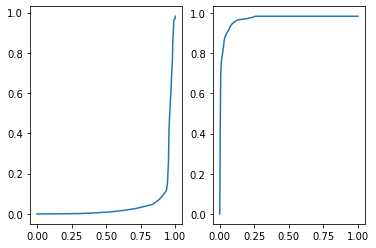

In [68]:
ran = np.arange(0,1,0.0001)
quant = np.quantile(train_pred,ran)
plt.subplot(1,2,1)
plt.plot(ran,quant)
plt.subplot(1,2,2)
plt.plot(ran, np.quantile(test_pred, ran))

In [39]:
lower_bound = 5.9425#np.quantile(test_pred_log, 0.28)
upper_bound = 5.9428#np.quantile(test_pred_log, 0.6)

for i in np.linspace(lower_bound,upper_bound, check_num):
    res[str(i)] = eval_measure(test_attack_level, test_pred_log, test_th=1/(sample_size+1.0), pred_th=i)
    print("pred_th = ",i, ", pre, rec, f1 =",res[str(i)])

pred_th =  5.9425 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942503030303031 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.9425060606060605 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942509090909091 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942512121212121 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942515151515152 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942518181818182 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942521212121212 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942524242424242 , pre, rec, f1 = (0.1435602613946563, 0.8747479838709677, 0.24664250692816034)
pred_th =  5.942527272727273 , pre, re

pred_th =  5.942730303030303 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942733333333333 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942736363636364 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.9427393939393935 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942742424242424 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942745454545455 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942748484848485 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942751515151516 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =  5.942754545454545 , pre, rec, f1 = (0.9444444444444444, 0.004284274193548387, 0.00852985449071751)
pred_th =

In [6]:



model_deep_dropout_sigmoid = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu,\
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_deep_dropout_sigmoid.compile(optimizer="Adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=["accuracy"])


W0901 18:11:30.938639 4635657664 deprecation.py:506] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 18:11:31.216025 4635657664 deprecation.py:323] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:



model_deep_dropout_sigmoid = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu,\
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_deep_dropout_sigmoid.compile(optimizer="Adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=["accuracy"])


W0901 18:11:30.938639 4635657664 deprecation.py:506] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 18:11:31.216025 4635657664 deprecation.py:323] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:



model_deep_dropout_sigmoid = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu,\
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, \
                          kernel_regularizer = tf.keras.regularizers.l2(0.01),\
                        activity_regularizer = tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_deep_dropout_sigmoid.compile(optimizer="Adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=["accuracy"])


W0901 18:11:30.938639 4635657664 deprecation.py:506] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 18:11:31.216025 4635657664 deprecation.py:323] From /Users/e0446225/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
